In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
%matplotlib inline
from scipy .stats import norm
import scipy.sparse.linalg as apsplg

# B-S PDE  
We denote: v as option price, t as time from 0, s as stock price, r as risk free rate
$$
\frac{\partial v}{\partial t} + \frac{\sigma^2 s^2}{2} \frac{\partial^2 v}{\partial s^2} + r s \frac{\partial v}{\partial s} = r v
$$

let
$$
 x = \log{s} 
$$
 $$
    \tau = T - t
$$
This will make 
#### 1.In the explicit matrix, all element are constant 
#### 2.We can use explict scheme and compute from T to 0 just using matrix multiplication

Finally get 
$$
 -\frac{\partial v}{\partial t} + (r - \frac{\sigma^2}{2}) \frac{\partial^2 v}{\partial s^2} + r s \frac{\partial v}{\partial s} = r v
$$

where
$$
\frac{\partial v}{\partial t} = \frac{v_{j,k+1} - v_{j,k}}{\Delta T} \\
$$
$$
\frac{\partial v}{\partial x} = \frac{v_{j+1,k} - v_{j-1,k}}{2 \Delta s}
$$
$$
\frac{\partial^2 v}{\partial s^2} = \frac{v_{j-1,k} - 2v_{j,k} + v_{j+1,k}}{\Delta x^2}
$$

At last get
$$
v_{j,k+1} = a v_{j-1,k} + b v_{j,k} + c v_{j+1,k}
$$
where 
$$
 a = \sigma^2 \frac{\Delta{T}}{2\Delta{x}^2} - (r - \frac{\sigma^2}{2})\frac{\Delta{T}}{2\Delta{x}}
$$

$$
 b = 1 - r\Delta{T} - \sigma^2\frac{\Delta{T}}{\Delta{x}^2}
$$

$$
 c =  (r - \frac{\sigma^2}{2})\frac{\Delta{T}}{2\Delta{x}} + \sigma^2 \frac{\Delta{T}}{2\Delta{x}^2}
$$

In [2]:
r = 0.1; sig = 0.2                
S0 = 100; X0 = np.log(S0)      
K = 100; Texpir = 1

In [14]:
Nspace = 200 * (5)   # M log price space steps
Ntime = 500  * (5**2)  # N time steps   
## note if you want to make Nspace*10, do Ntime*100 to make sure the explicit matrix is stable

S_max = 3*float(K)                
S_min = float(K)/3

x_max = np.log(S_max)  # A2
x_min = np.log(S_min)  # A1


In [29]:
x, dx = np.linspace(x_min, x_max, Nspace, retstep=True)   # space discretization
T, dt = np.linspace(0, Texpir, Ntime, retstep=True)       # time discretization
Payoff = (np.exp(x)-K > 0).astype(float)        # Call payoff

In [42]:
V = np.zeros((Nspace,Ntime))       # grid initialization
boundary = np.zeros(Nspace-2)        # vector to be used for the boundary terms   

V[:,0] = Payoff                   # terminal conditions 
V[-1,:] = (np.exp(x_max) - K> 0).astype(float)  * np.exp(-r* T )# boundary condition
V[0,:] = 0   

In [43]:
a = (sig**2 * (dt) / (2*(dx**2))) - (r - (sig**2) / 2) * (dt / (2*dx))
b =  1 - r*dt - (sig**2) * (dt / (dx**2))
c = (r - (sig**2) / 2) * dt / (2*dx) + sig**2 * dt / (2*(dx**2))
A =  np.zeros(shape = (Nspace - 2,Nspace - 2))
A[1:,:-1] = np.diag([a] * (Nspace - 3))
B = np.diag([b] * (Nspace - 2))
C = np.zeros(shape = (Nspace - 2,Nspace - 2))
C[:-1,1:] = np.diag([c] * (Nspace - 3))

Mat = A + B + C

In [44]:
for k in tqdm.tqdm(range(0,Ntime - 1)):
    boundary[0] = a * V[0,k]
    boundary[-1] = c * V[-1,k]
    V[1:-1,k + 1] = Mat @ V[1:-1,k] + boundary
    #assert (V[:,0] <= V[:,1]).sum()== 2000
    assert V[1:-1,k + 1].min() >= 0
    assert pd.isna(V[1:-1,k + 1]).sum() == 0


100%|██████████| 12499/12499 [00:11<00:00, 1089.38it/s]


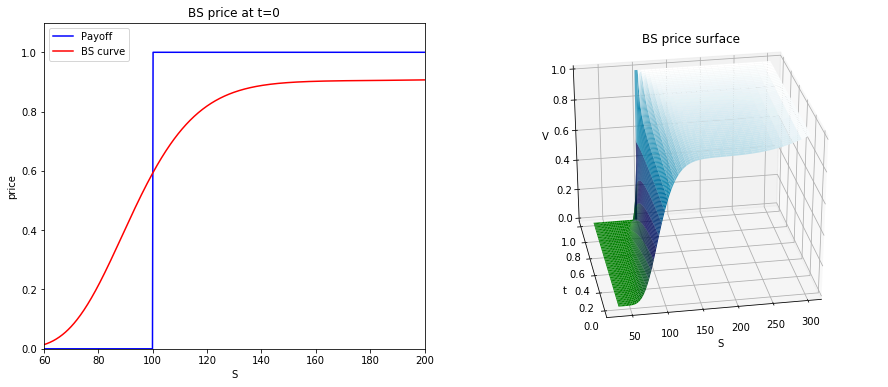

In [33]:

S = np.exp(x)
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

ax1.plot(S, Payoff, color='blue',label="Payoff")
ax1.plot(S, V[:,-1], color='red',label="BS curve")
ax1.set_xlim(60,200); ax1.set_ylim(0,1.1)
ax1.set_xlabel("S"); ax1.set_ylabel("price")
ax1.legend(loc='upper left'); ax1.set_title("BS price at t=0")

X, Y = np.meshgrid(T[::-1], S)
ax2.plot_surface(Y, X, V, cmap=cm.ocean)
ax2.set_title("BS price surface")
ax2.set_xlabel("S"); ax2.set_ylabel("t"); ax2.set_zlabel("V")
ax2.view_init(30, -100) # this function rotates the 3d plot
plt.show()

In [45]:
def bs_formula_binary(S0,K,sig,T,r):
    d1 = (np.log(S0 / K) + (r + 0.5 * (sig**2)) *T) / (sig*np.sqrt(T))
    d2 = d1 - sig*np.sqrt(T)
    return np.exp(-r*T) * norm.cdf(d2)

In [46]:
price = np.stack((S,V[:,-1],bs_formula_binary(S,100,sig,1,r)),axis = 1)

In [41]:
np.exp(-r)

0.9048374180359595